APE by forecast step:
 h
t+1    0.038636
t+2    0.075262
t+3    0.109433
Name: APE, dtype: float64
One step forecast MAPE: 3.86%
Multi-step forecast MAPE: 7.44%


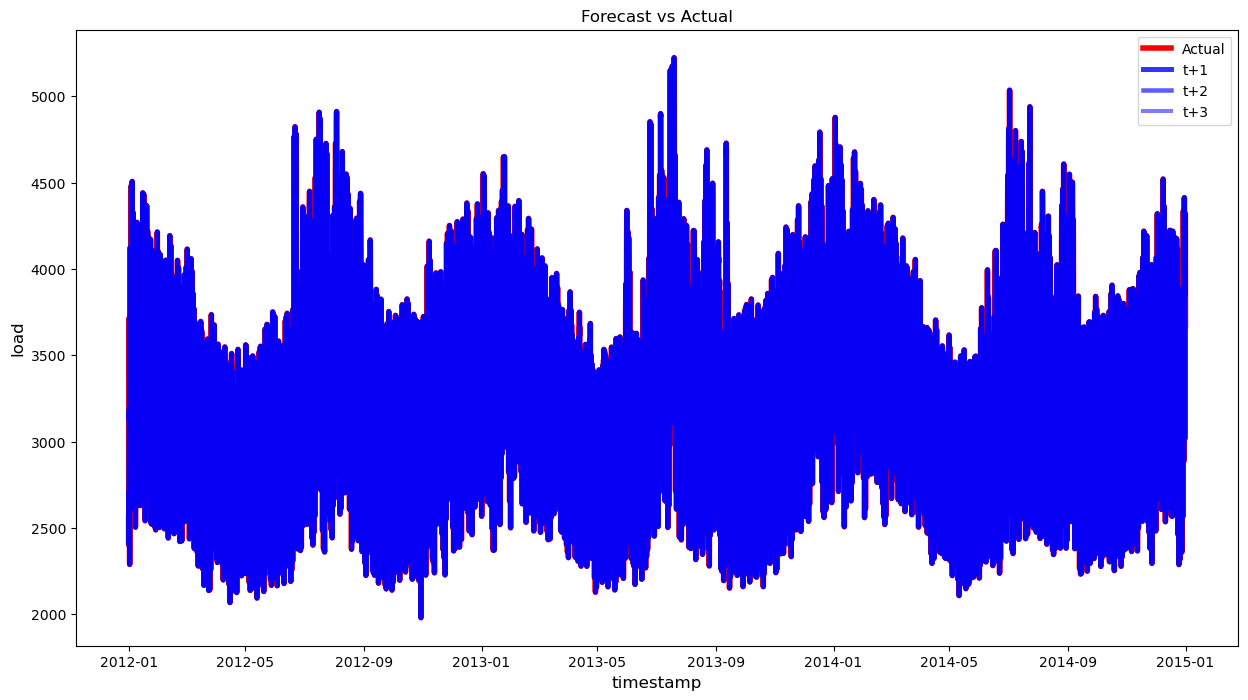

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Step 1: Load dataset
df = pd.read_csv('energy.csv', parse_dates=['timestamp'])

# Step 2: Define forecast horizon
HORIZON = 3  # You can change this to any integer >= 1

# Step 3: Simulate naive multi-step forecasts using shifted actuals
for t in range(1, HORIZON + 1):
    df[f'prediction_t+{t}'] = df['load'].shift(t)

# Step 4: Build eval_df with actual, prediction, timestamp, and forecast step 'h'
eval_df = pd.DataFrame()
for t in range(1, HORIZON + 1):
    temp_df = pd.DataFrame({
        'timestamp': df['timestamp'],
        'actual': df['load'],
        'prediction': df[f'prediction_t+{t}'],
        'h': f't+{t}'
    })
    eval_df = pd.concat([eval_df, temp_df], ignore_index=True)

# Step 5: Drop NaNs caused by shifting
eval_df.dropna(inplace=True)

# Step 6: Define MAPE function
def mape(pred, actual):
    return (abs(pred - actual) / actual).mean()

# Step 7: APE analysis if multi-step
if HORIZON > 1:
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print("APE by forecast step:\n", eval_df.groupby('h')['APE'].mean())

# Step 8: Print one-step and multi-step MAPE
mape_one_step = mape(
    eval_df[eval_df['h'] == 't+1']['prediction'],
    eval_df[eval_df['h'] == 't+1']['actual']
) * 100

mape_multi_step = mape(eval_df['prediction'], eval_df['actual']) * 100

print(f"One step forecast MAPE: {mape_one_step:.2f}%")
print(f"Multi-step forecast MAPE: {mape_multi_step:.2f}%")

# Step 9: Plotting
if HORIZON == 1:
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))
else:
    # Align all series properly using index reset and truncation
    plot_df = eval_df[eval_df['h'] == 't+1'][['timestamp', 'actual']].copy().reset_index(drop=True)

    for t in range(1, HORIZON + 1):
        pred_series = eval_df[eval_df['h'] == f't+{t}']['prediction'].reset_index(drop=True)
        min_len = min(len(plot_df), len(pred_series))
        plot_df = plot_df.iloc[:min_len]
        plot_df[f't+{t}'] = pred_series.iloc[:min_len].values

    # Plot actual and all predictions
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0, label='Actual')

    for t in range(1, HORIZON + 1):
        ax.plot(plot_df['timestamp'], plot_df[f't+{t}'],
                color='blue', linewidth=4 * math.pow(0.9, t),
                alpha=math.pow(0.8, t), label=f't+{t}')

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.title('Forecast vs Actual')
plt.show()